# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import tissue_enrichment_analysis as tea
import bokeh

from scipy import stats

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [7]:
q = 0.1
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../output/dpy_22_results.csv')
mediator = pd.read_csv('../input/complexes.csv')

In [3]:
tissue = tea.fetch_dictionary('tissue')
phenotype = tea.fetch_dictionary('phenotype')
go = tea.fetch_dictionary('go')

In [4]:
def melt(df):
    """A melt function for the tea dictionaries."""
    expression = pd.melt(df, id_vars='wbid', var_name='term')
    expression = expression[expression.value == 1]
    return expression[['wbid', 'term']]

expression = melt(tissue)
phenom = melt(phenotype)
gom = melt(go)

In [123]:
def get_melted_dictionary(kind='tissue'):
    if kind not in ['phenotype', 'go', 'tissue']:
        raise ValueError('dictionary must be one of `dictionary`, `go` or `tissue`.')
    if kind is 'tissue':
        temp = tissue
    elif kind is 'phenotype':
        temp = phenotype
    else:
        temp = go
    df = melt(temp)
    return df


def extract_term_ids(term, df, q=0.1, cond=True):
    terms = df[df.term.str.lower().str.contains(term.lower())].term.unique()
    if len(terms) > 1:
        print('Warning, more than 1 term was pulled out of the dictionary.')
        print(df[df.term.str.lower().str.contains(term.lower())].term.unique())

    ids = df[df.term.str.lower().str.contains(term.lower())].wbid
    if len(ids) == 0:
        raise ValueError('No genes found with term {0}.'.format(term))

    data = tidy[(tidy.qval < q) & (tidy.ens_gene.isin(ids)) & cond]
    return ids, data, terms
    


def plot_by_term(term, dictionary, q=0.1, x='b', y='genotype', **kwargs):
    jitter = kwargs.pop('jitter', True)
    cond = kwargs.pop('cond', True)
    df = get_melted_dictionary(kind=dictionary)
    ids, data, terms = extract_term_ids(term, df, q=0.1)
#     if dictionary not in ['phenotype', 'go', 'tissue']:
#         raise ValueError('dictionary must be one of `dictionary`, `go` or `tissue`.')
#     if dictionary is 'tissue':
#         temp = tissue
#     elif dictionary is 'phenotype':
#         temp = phenotype
#     else:
#         temp = go
#     df = melt(temp)
#     terms = df[df.term.str.lower().str.contains(term.lower())].term.unique()
#     if len(terms) > 1:
#         print('Warning, more than 1 term was pulled out of the dictionary.')
#         print(df[df.term.str.lower().str.contains(term.lower())].term.unique())
#     ids = df[df.term.str.lower().str.contains(term.lower())].wbid
    if len(ids) == 0:
        raise ValueError('No genes found with this term.')
    
    data = tidy[(tidy.qval < q) & (tidy.ens_gene.isin(ids)) & cond]
    if len(data) < 150:
        sns.stripplot(x=x, y=y, data=data, jitter=jitter, **kwargs)
    else:
        sns.boxplot(x=x, y=y, data=data, **kwargs)
    plt.axvline(0, color='red', ls='--', lw=1)
    
    if len(terms) == 1:
        plt.title(terms[0])
    
    return plt.gca(), ids

In [142]:
def ea(dictionary=tissue, q=0.001, filter_level=1):
    results = {}
    for name, group in tidy.groupby('phenotypic class'):
        wbids = group.ens_gene.unique()
        df = tea.enrichment_analysis(wbids, dictionary, show=False, alpha=q)
        results[name] = df[df['Enrichment Fold Change'] > filter_level]
    return results

def print_ea(results, n=25):
    for key, value in results.items():
        print(key)
        print(value[['Tissue', 'Enrichment Fold Change', 'Q value']].head(n))
        print('\n\n\n')

In [143]:
tissue_results = ea(tissue)
print_ea(tissue_results)

transhet specific
                               Tissue  Enrichment Fold Change       Q value
164                 male WBbt:0007850                1.958449  1.663272e-41
182  reproductive system WBbt:0005747                1.299693  9.950548e-20




bx93 specific
Empty DataFrame
Columns: [Tissue, Enrichment Fold Change, Q value]
Index: []




bx93 associated
                    Tissue  Enrichment Fold Change       Q value
51  intestine WBbt:0005772                1.707064  3.300261e-09




sy622 associated
                     Tissue  Enrichment Fold Change   Q value
185  intestine WBbt:0005772                1.266764  0.000463




sy622 specific
                                 Tissue  Enrichment Fold Change       Q value
174              intestine WBbt:0005772                1.373140  1.099422e-16
116        muscular system WBbt:0005737                1.281602  2.648891e-08
80   anal depressor muscle WBbt:0004292                1.902804  8.384304e-07
156      epithelial system WBbt:0

In [144]:
phenotype_results = ea(phenotype)
print_ea(phenotype_results)

transhet specific
Empty DataFrame
Columns: [Tissue, Enrichment Fold Change, Q value]
Index: []




bx93 specific
Empty DataFrame
Columns: [Tissue, Enrichment Fold Change, Q value]
Index: []




bx93 associated
Empty DataFrame
Columns: [Tissue, Enrichment Fold Change, Q value]
Index: []




sy622 associated
Empty DataFrame
Columns: [Tissue, Enrichment Fold Change, Q value]
Index: []




sy622 specific
                                                Tissue  \
50           avoids bacterial lawn WBPhenotype:0000402   
169              gonad vesiculated WBPhenotype:0001979   
213  pleiotropic defects severe early emb WBPhenoty...   

     Enrichment Fold Change       Q value  
50                 1.927582  1.801068e-07  
169                2.035306  2.835982e-04  
213                2.276403  6.537916e-04  






In [145]:
go_results = ea(go, filter_level=2)
print_ea(go_results, n=50)

transhet specific
                                                Tissue  \
221                   developmental process GO:0032502   
290                            reproduction GO:0000003   
222                      embryo development GO:0009790   
282              post-embryonic development GO:0009791   
11   development of primary sexual characteristics ...   
121         reproductive system development GO:0061458   
233     multi-organism reproductive process GO:0044703   
252                                   aging GO:0007568   
125                              cell death GO:0008219   
164                    localization of cell GO:0051674   
17               meiotic cell cycle process GO:1903046   
255                regulation of cell shape GO:0008360   
70                        organelle fission GO:0048285   
107            peptidyl-serine modification GO:0018209   
172                  chromosome segregation GO:0007059   
244      posttranscriptional gene silencing GO:0016441

In [38]:
mediator[mediator.ens_gene.isin(tidy[(tidy.ens_gene.isin(mediator.ens_gene)) & (tidy.qval < q)].ens_gene)]

,ext_gene,ens_gene,complex,module,comments
0,cdk-8,WBGene00000409,mediator,kinase,NaN
2,dpy-22,WBGene00001081,mediator,kinase,NaN
9,mdt-15,WBGene00007016,mediator,tail,NaN
11,mdt-18,WBGene00007018,mediator,head,NaN
12,mdt-19,WBGene00007019,mediator,middle,NaN
23,mdt-6,WBGene00003164,mediator,head,NaN
25,mdt-9,WBGene00014938,mediator,middle,NaN
27,sop-3,WBGene00004946,mediator,middle,NaN


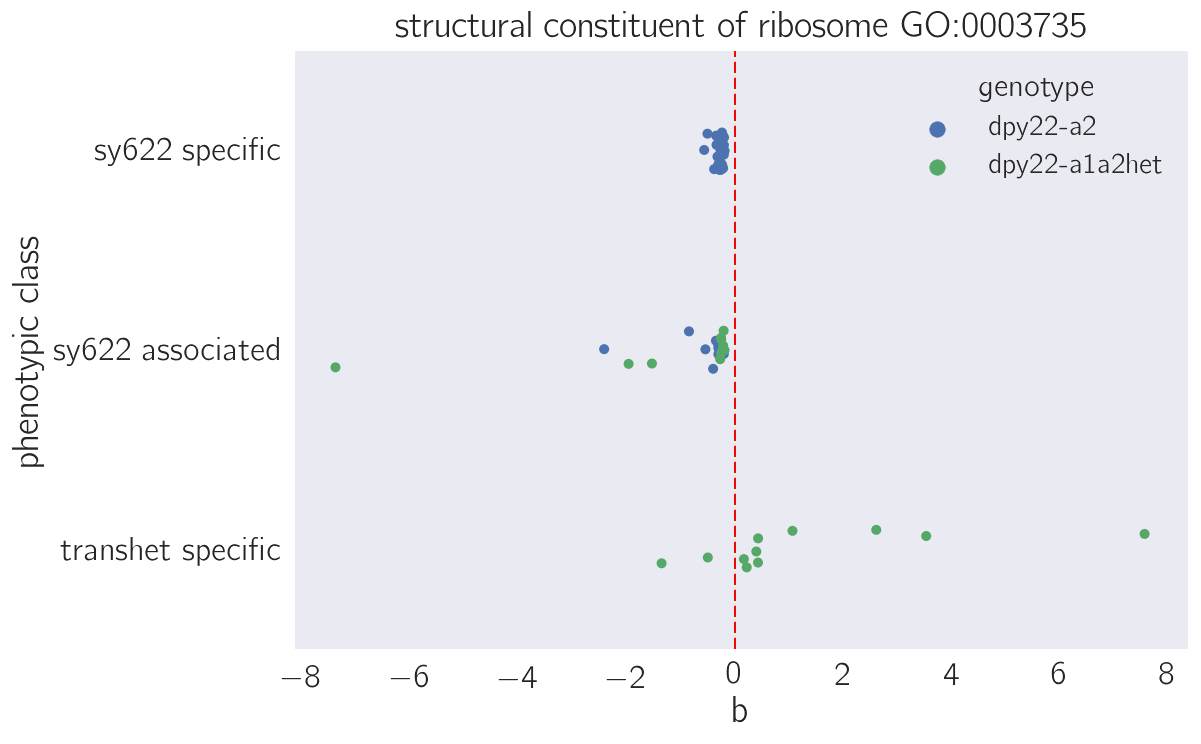

In [125]:
ax, ids = plot_by_term('ribosome', 'go', y='phenotypic class', hue='genotype')

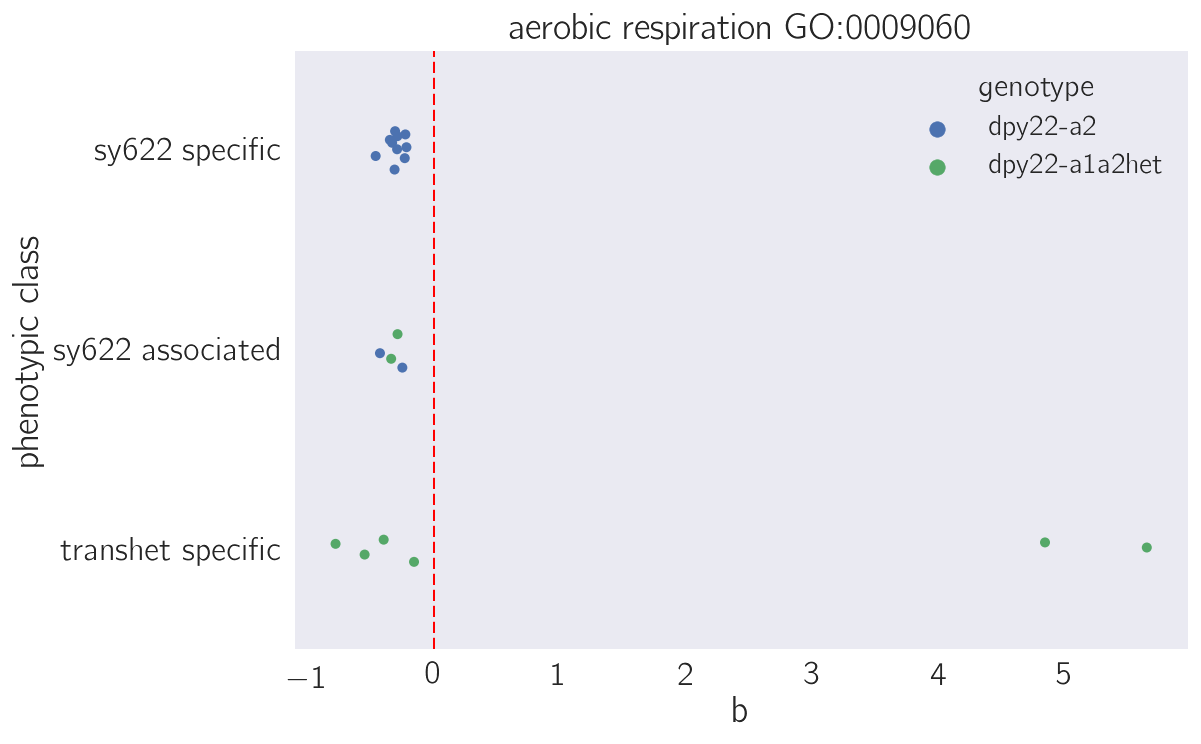

In [126]:
ax, ids = plot_by_term('respiration', 'go', y='phenotypic class', hue='genotype')

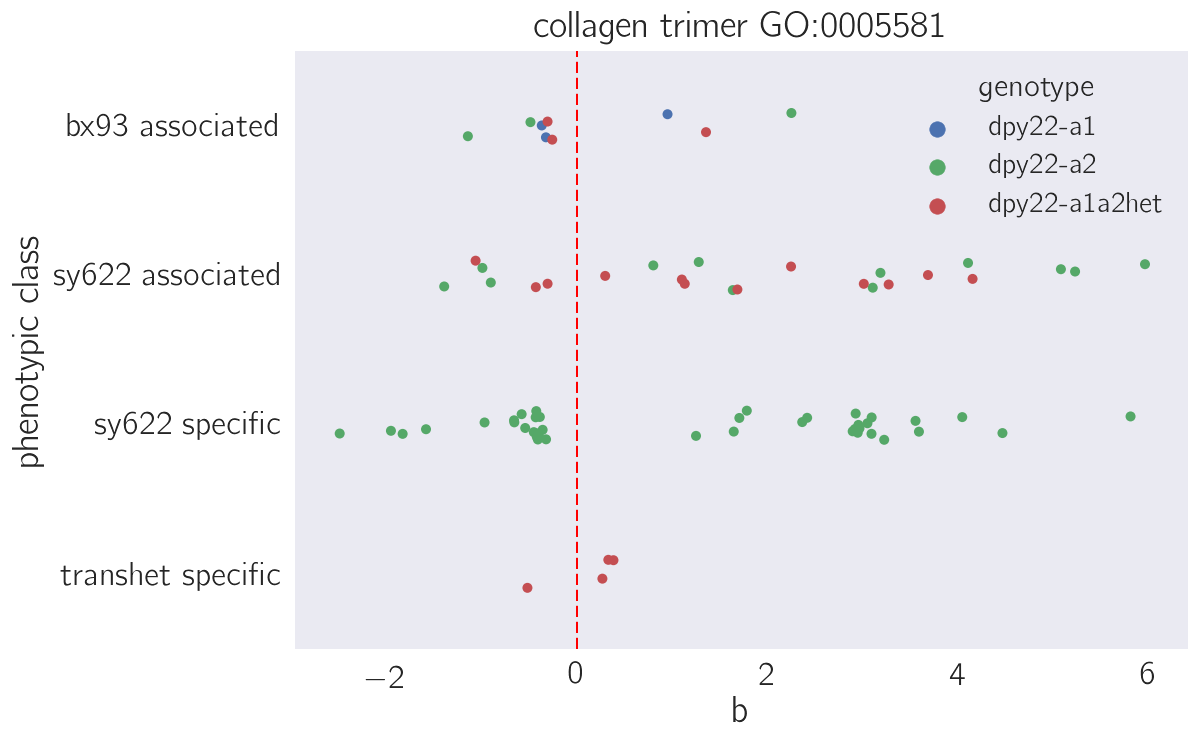

In [169]:
ax, ids = plot_by_term('collagen trimer', 'go', y='phenotypic class', hue='genotype')

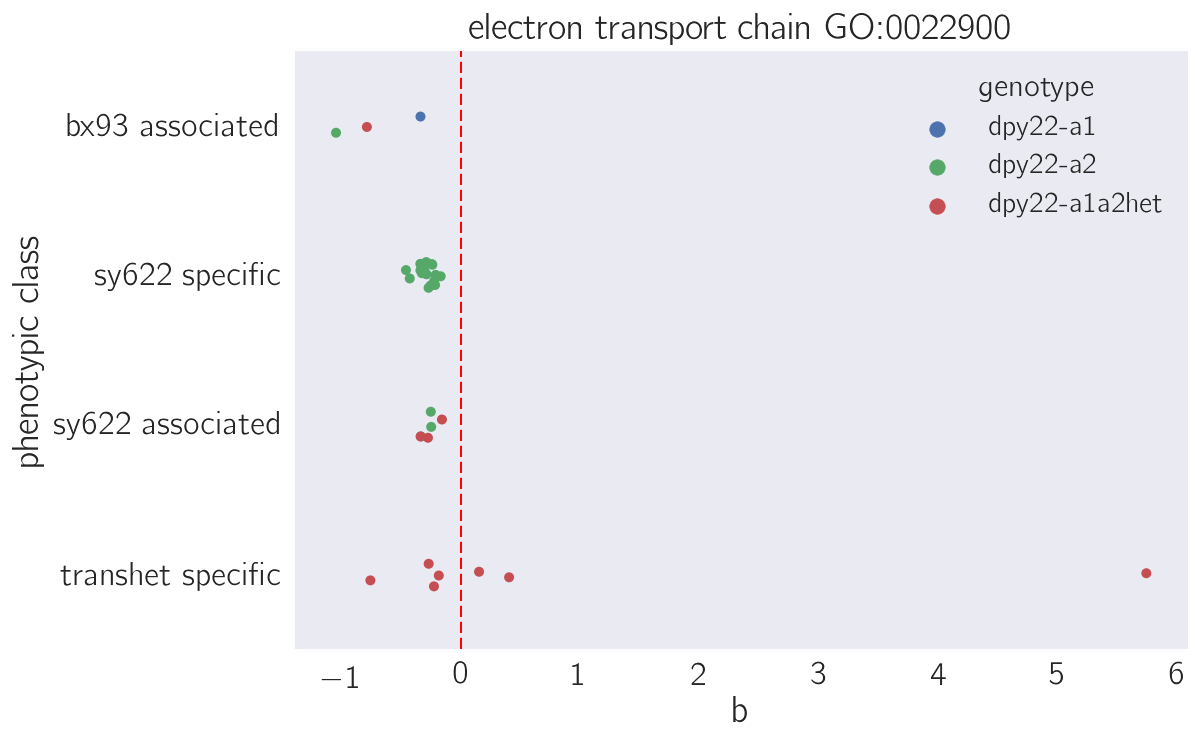

In [147]:
 ax, ids = plot_by_term('electron transport chain', 'go', y='phenotypic class', hue='genotype')

In [175]:
len(tidy[(tidy.ens_gene.isin(ids)) & (tidy.qval < q) & (tidy['phenotypic class'] == 'sy622 specific')].ens_gene.unique())

38

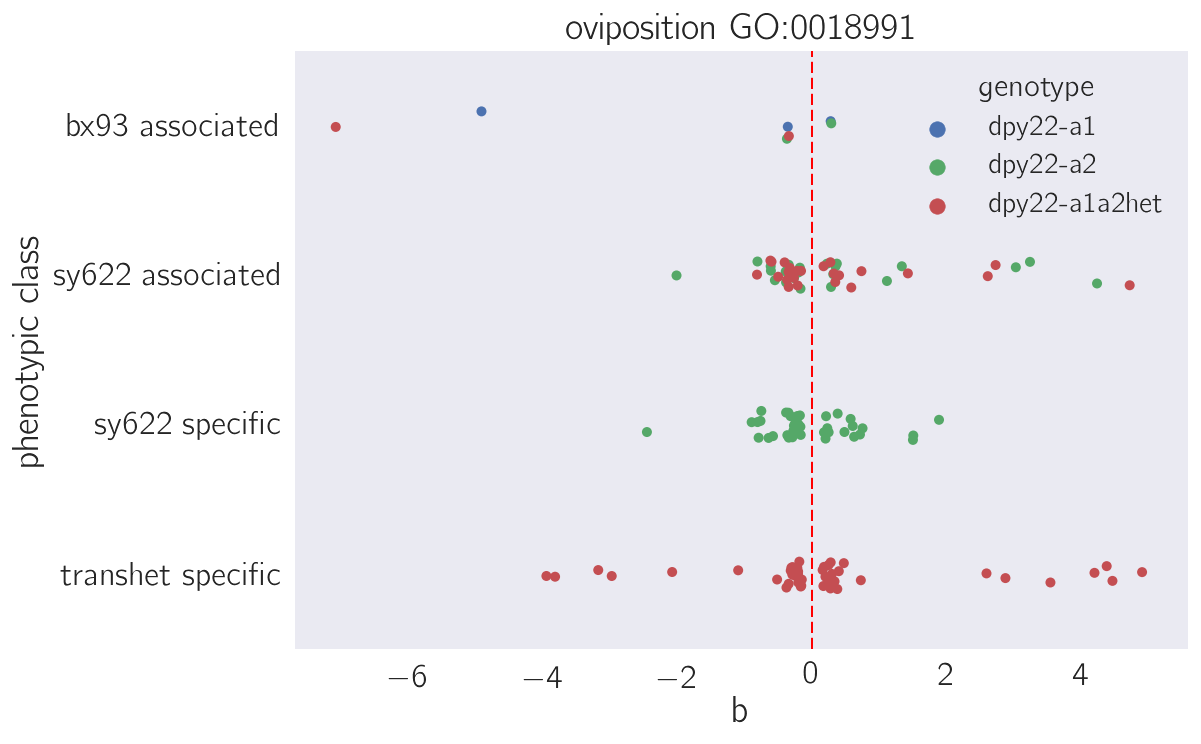

In [173]:
ax, ids = plot_by_term('oviposition', 'go', y='phenotypic class', hue='genotype')

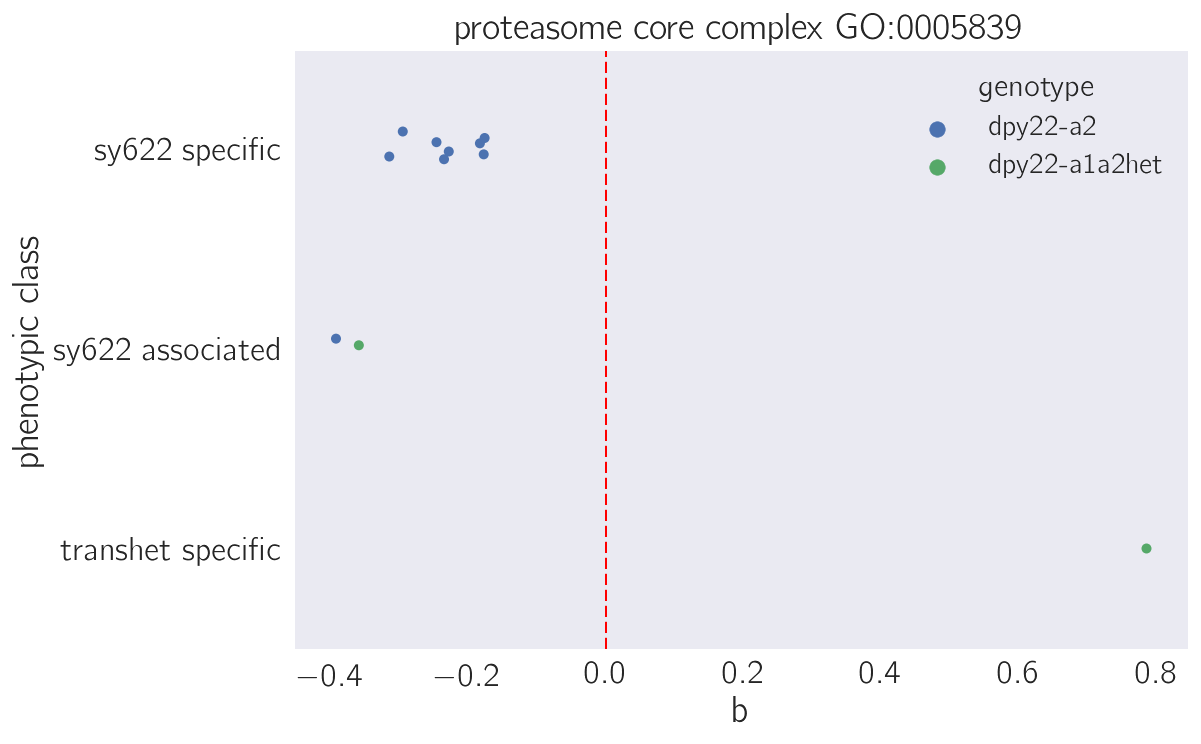

In [179]:
ax, ids = plot_by_term('proteasome', 'go', y='phenotypic class', hue='genotype')

In [188]:
tidy[(tidy.qval < q) & (tidy.target_id == 'ftn-1')]

,Unnamed: 0,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,ens_gene,ext_gene,strain,genotype,phenotypic class


In [189]:
hypoxia = pd.read_csv('../input/hypoxia_response.csv')

In [192]:
tidy[(tidy.qval < q) & (tidy.target_id.isin(hypoxia.target_id))].shape

(424, 17)

In [209]:
# hypergeometric test
for name, group in tidy[(tidy.qval < q)].groupby('genotype'):
    found = group[(group.target_id.isin(hypoxia.target_id))]
    print(name, group.shape[0], found.shape[0])
    print('pval {0:.2g}'.format(stats.hypergeom.sf(len(found), len(tidy.target_id.unique()), len(hypoxia), len(group))))

dpy22-a1 343 56
pval 7.7e-33
dpy22-a1a2het 2740 123
pval 6.5e-15
dpy22-a2 2614 245
pval 4.2e-98


In [218]:
# mann whitney u
for name, group in tidy[(tidy.qval < q)].groupby('genotype'):
    found = group[(group.target_id.isin(hypoxia.target_id))]
    print(name, group.shape[0], found.shape[0])
    mwu = stats.mannwhitneyu(group.sort_values('target_id').b, hypoxia.sort_values('target_id').b)
    print('pval {0:.2g}'.format(mwu.pvalue))
    x = found.b
    y = hypoxia[hypoxia.target_id.isin(found.target_id)].b
    print('correlation {0:.2g}'.format(stats.spearmanr(x, y).correlation))

dpy22-a1 343 56
pval 1.6e-11
correlation -0.072
dpy22-a1a2het 2740 123
pval 5.2e-11
correlation -0.017
dpy22-a2 2614 245
pval 1.1e-11
correlation 0.036


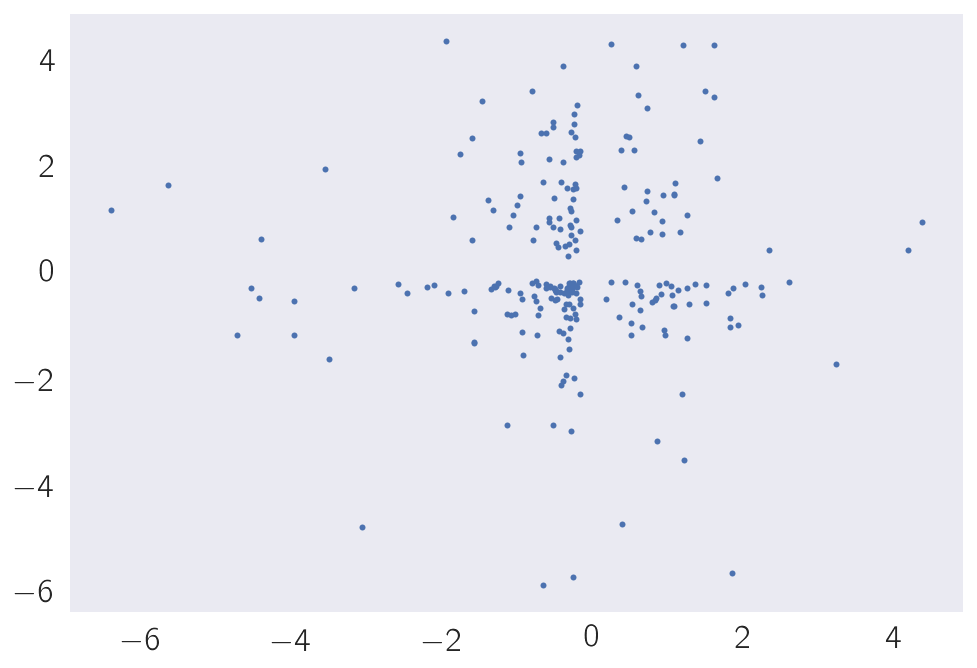

In [222]:
x = group[(group.target_id.isin(hypoxia.target_id))].sort_values('target_id')
y = hypoxia[hypoxia.target_id.isin(x.target_id)]
plt.plot(x.b, y.b, 'o', ms=3)

In [219]:
test = stats.pearsonr(x, y)

In [220]:
test

(0.021131382255630035, 0.74207731800613563)